# Plant Disease Detection using Convoluted Neural Netwroks

In [ ]:
import json
import os
import shutil
import random

The path to the dataset.
The dataset is in the folder 'Dataset'.
Please upload the folder here.
Or you can mount the dataset by running the mount section.

In [ ]:
root = '/content/Dataset'

The mount section.
Do not run this section if you run the above section.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root = 'content/Dataset'


Creating the lables using the directory names.

In [ ]:
#Creating the labels
files = os.listdir(root)
categories = {}
for disease in files:
    categories.update({disease : disease})
categories

{'apple-black-rot': 'apple-black-rot',
 'apple-cedar-rust': 'apple-cedar-rust',
 'apple-scab': 'apple-scab',
 'apple-healthy': 'apple-healthy'}

Storing the labes in a json file to use it in the future.

In [ ]:
with open("label.json", "w") as outfile:
    json.dump(categories, outfile)

Splitting the data set into: Train, Test and Valid
Train: Used to train the model
Test: Used to test the model
Valid: Used while predicting

In [ ]:
# Splitting the data into train, test and validation set
split_root = 'data-split/'
split_names = ['train','test','valid']
for sp_name in split_names:
    directory = split_root + sp_name + '/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    # make category folders
    for category in categories.keys():
        dir_cat = directory + category + '/'
        if not os.path.exists(dir_cat):
            os.makedirs(dir_cat)

Storing the Train, Test and Valid images in three different directories.
data-split/train
data-plit/test
data-split/valid

In [ ]:
for category in categories.keys():
    count = 0
    data_directory = root + '/' + category + '/'
    directory_train = split_root + 'train/' + category + '/'
    directory_valid = split_root + 'test/' + category + '/'
    directory_test = split_root + 'valid/' + category + '/'
    print(root)

    # sort files into test and valid folders
    filenames = os.listdir(data_directory)
    filenames.sort()
    if '.DS_Store' in filenames:
        filenames.remove('.DS_Store')
    random.shuffle(filenames)
    split_1 = int(0.8 * len(filenames))
    split_2 = int(0.9 * len(filenames))
    train_filenames = filenames[:split_1]
    valid_filenames = filenames[split_1:split_2]
    test_filenames = filenames[split_2:]

    for image_file in filenames:
        if image_file in valid_filenames:
            shutil.copy(data_directory + image_file, directory_valid + image_file)
            cur_file = directory_valid + image_file
            new_file = directory_valid + category + str(count) + '.jpg'
            count += 1
            os.rename(cur_file, new_file)
        elif image_file in test_filenames:
            shutil.copy(data_directory + image_file, directory_test + image_file)
            cur_file = directory_test + image_file
            new_file = directory_test + category + str(count) + '.jpg'
            count += 1
            os.rename(cur_file, new_file)
        elif image_file in train_filenames:
            shutil.copy(data_directory + image_file, directory_train + image_file)
            cur_file = directory_train + image_file
            new_file = directory_train + category + str(count) + '.jpg'
            count += 1
            os.rename(cur_file, new_file)

/content/drive/MyDrive/Dataset
/content/drive/MyDrive/Dataset
/content/drive/MyDrive/Dataset
/content/drive/MyDrive/Dataset


Importing the modules for building the CNN model.

In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
# from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

Augmenting the data using ImageDataGenerator to make the model better.

In [ ]:
# ImageDataGenerator for training dataset
train_gen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=40,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [ ]:
# ImageDataGenerator for validation dataset
valid_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
# ImageDataGenerator for test dataset
test_gen = ImageDataGenerator(rescale=1./255)

The batch size while training the model is set to 39. Set after trial and error for better training.

In [ ]:
batch_size = 39
train_data_dir = "data-split/train"
valid_data_dir = "data-split/valid"
test_data_dir = "data-split/test"

Getting the data and assiging labels for categories

In [ ]:

training_set = train_gen.flow_from_directory(train_data_dir,
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

valid_set = valid_gen.flow_from_directory(valid_data_dir,
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='categorical')

test_set = test_gen.flow_from_directory(test_data_dir,
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='categorical')

print(training_set.class_indices)

Found 2536 images belonging to 4 classes.
Found 319 images belonging to 4 classes.
Found 316 images belonging to 4 classes.
{'apple-black-rot': 0, 'apple-cedar-rust': 1, 'apple-healthy': 2, 'apple-scab': 3}


# Initializing the model

In [ ]:

model = Sequential()

Adding a 2D convolution layer to the model


*   96: This specifies the number of filters (or kernels) in
the convolutional layer. Each filter learns different features from the input data.
*   11: This specifies the size of each filter kernel. In this case, it's an 11x11 filter.
This defines the shape of the input data expected by the layer. It expects input images of size 224x224 pixels with 3 channels (RGB).
* strides=(4, 4): This defines the stride of the convolution operation. A stride of (4, 4) means that the filter moves 4 pixels at a time along both the height and width dimensions of the input volume.
padding='valid': This specifies the padding mode. 'Valid' padding means no padding is added to the input volume before applying the convolution operation.
* activation='relu': This specifies the activation function used after applying the convolution operation. Here, 'relu' (Rectified Linear Unit) activation is used.



# Each block is a new layer to the CNN model.


In [ ]:
# Convolution Layer
model.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(224, 224, 3), activation = 'relu'))

# Max Pooling Layer
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))

# Batch Normalization
model.add(BatchNormalization())

In [ ]:
# Convolution Layer
model.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))

# Max Pooling Layer
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))

# Batch Normalization
model.add(BatchNormalization())

In [ ]:
# Convolution Layer
model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))

# Batch Normalization
model.add(BatchNormalization())

In [ ]:
# Convolution Layer
model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))

# Batch Normalization
model.add(BatchNormalization())

In [ ]:
# Convolution Layer
model.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))

# Max Pooling Layer
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))

# Batch Normalization
model.add(BatchNormalization())

In [ ]:
# Flattening Step
model.add(Flatten())

Combines fully connected layers with dropout regularization and batch normalization to create a deep neural network capable of learning complex patterns in the data and making predictions with high accuracy.

Dropout Normalization prevent over fitting.
Batch Normalization provides more stabilised training.









In [ ]:
# Full Connection Step
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(units = 1000, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(units = 4, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 27, 27, 96)        384       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 256)         0         
 g2D)                                                            
                                                      

# Compile the model

In [ ]:

# model.compile(optimizer=optimizers.SGD(lr=0.001, momentum=0.9, decay=0.005),
#                    loss='categorical_crossentropy',
#                    metrics=['accuracy'])
from tensorflow.keras.optimizers import legacy

model.compile(optimizer=legacy.SGD(lr=0.001, momentum=0.9, decay=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])




/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Fitting the model with 25 epochs.

In [ ]:
history = model.fit(training_set,
                                   steps_per_epoch=training_set.samples//batch_size,
                                   validation_data=valid_set,
                                   epochs=25,
                                   validation_steps=valid_set.samples//batch_size)

Epoch 1/25
65/65 [==============================] - 529s 8s/step - loss: 1.4182 - accuracy: 0.4786 - val_loss: 1.2313 - val_accuracy: 0.5128
Epoch 2/25
65/65 [==============================] - 466s 7s/step - loss: 1.0809 - accuracy: 0.6316 - val_loss: 1.1631 - val_accuracy: 0.4776
Epoch 3/25
65/65 [==============================] - 456s 7s/step - loss: 0.9772 - accuracy: 0.6456 - val_loss: 0.9159 - val_accuracy: 0.6442
Epoch 4/25
65/65 [==============================] - 477s 7s/step - loss: 0.9251 - accuracy: 0.6608 - val_loss: 0.7991 - val_accuracy: 0.6827
Epoch 5/25
65/65 [==============================] - 481s 7s/step - loss: 0.8818 - accuracy: 0.6780 - val_loss: 0.6772 - val_accuracy: 0.7115
Epoch 6/25
65/65 [==============================] - 472s 7s/step - loss: 0.8270 - accuracy: 0.7024 - val_loss: 0.6148 - val_accuracy: 0.7564
Epoch 7/25
65/65 [==============================] - 474s 7s/step - loss: 0.7713 - accuracy: 0.7137 - val_loss: 0.5711 - val_accuracy: 0.7917
Epoch 8/25
65

# Save the model

In [ ]:

filepath="~/Desktop/AI/model-cnn.hdf5"
model.save(filepath)

#Plotting training values

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#Accuracy plot

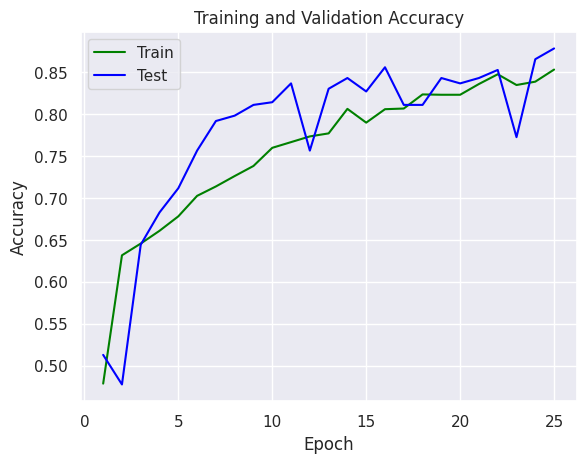

In [ ]:

plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

#Loss plot

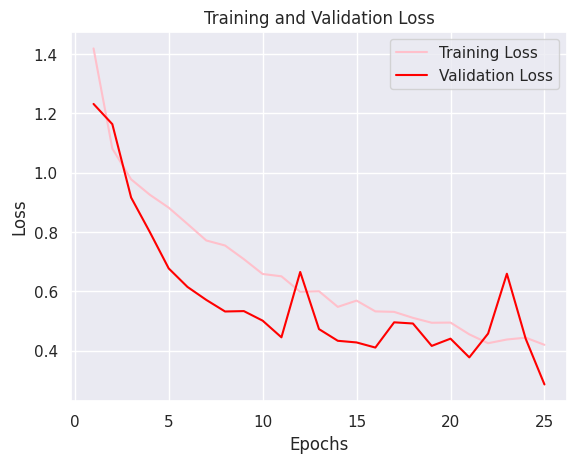

In [ ]:

plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
results = model.evaluate(test_set, steps=test_set.samples//batch_size)

8/8 [==============================] - 12s 1s/step - loss: 0.2713 - accuracy: 0.9038


In [ ]:
print("Accuracy = {:2f}".format(results[1]*100))

Accuracy = 90.384614


Importing modules for prediction.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import imutils
from keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.image import img_to_array
from keras.models import load_model

# model = load_model("model-cnn.hdf5")
# Load Labels
with open('label.json', 'r') as f:
  cat = json.load(f)
categories_idx = list(cat.keys())
categories_idx


['apple-black-rot', 'apple-cedar-rust', 'apple-scab', 'apple-healthy']

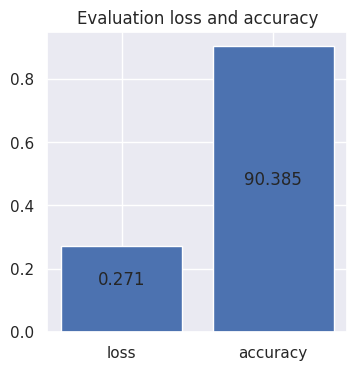

In [ ]:
fig= plt.figure(figsize=(3,3))
ax =fig.add_axes([0,0,1,1])
para = ['loss', 'accuracy']
loss= round(results[0],3)
acc= round(results[1]*100,3)
vals= [loss,acc]
barplot =plt.bar (para, results)
for idx, rect in enumerate(barplot):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width()/2., 0.5* height, vals [idx], ha='center', va='bottom')
plt.title("Evaluation loss and accuracy")
plt.show()

In [ ]:
test_labels = training_set.classes

In [ ]:
predictions = model.predict(training_set)

66/66 [==============================] - 188s 3s/step


In [ ]:
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Greens):
#This function prints and plots the confusion matrix.
#Normalization can be applied by setting normalize=True`.
  plt.figure(figsize=(15, 8))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks (tick_marks, classes)
  plt.yticks (tick_marks, classes)
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.grid(False)
  plt.ylabel("True label")
  plt.xlabel("Predicted label")



#Confusion matrix using the results of the model on the test set

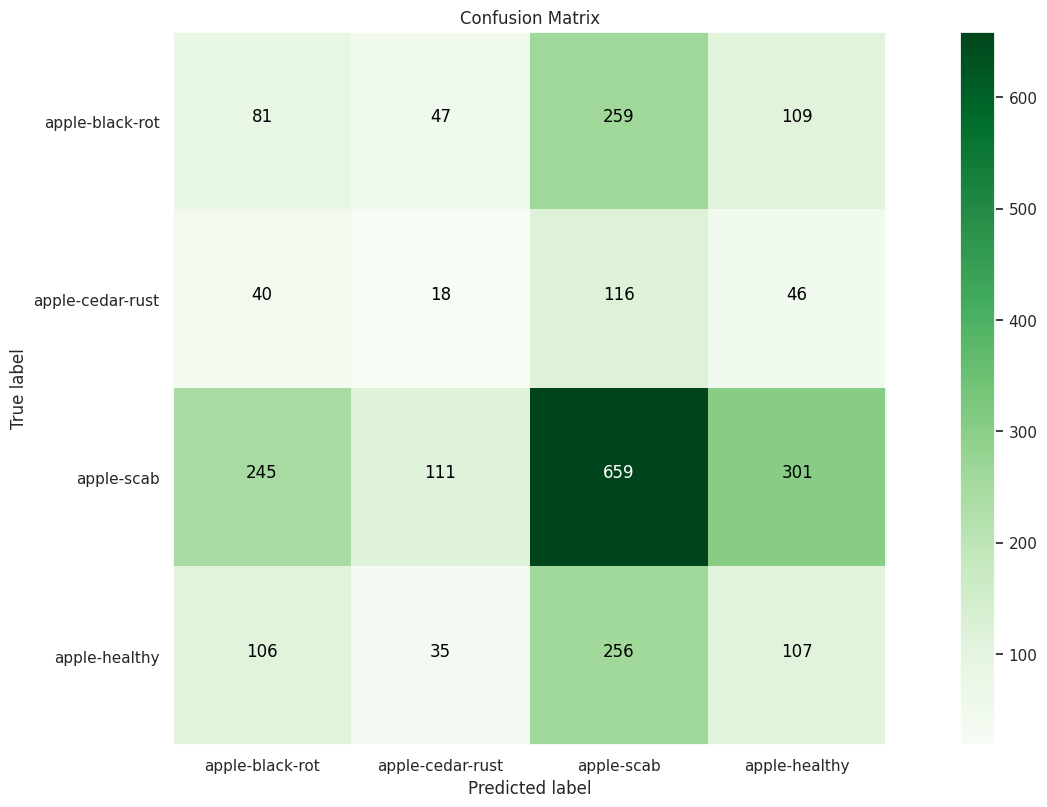

In [ ]:

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

In [ ]:
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import imutils
# categories_idx = {0:'apple-black-rot', 1:'apple-cedar-rust',2: 'apple-healthy',3: 'apple-scab'}
def get_predictions (image, model):

  vals = []
  output = image.copy()

  # Preprocess the image for classification
  image = cv2.resize(image, (224, 224))
  image = image.astype("float") / 255.0
  image =img_to_array(image)
  image =np.expand_dims(image, axis=0)

  #Make the predictions
  proba = model.predict(image)[0]
  for i in range(len(proba)):
    idx= np.argmax(proba)
    label= categories_idx[i]
    acc = "{:.2f}% ".format(proba[i] * 100)
    vals.append([label,acc])

  # Display the predictions

  output = imutils.resize(output, width=400)
  fig, ax = plt.subplots()
  ax.set_axis_off()
  table = ax.table(cellText = vals,rowLabels = None,colLabels = ['Class', 'Certainity'],rowColours =None,
    colColours =["lightgreen"] * 2,
    cellLoc='center',
    loc ='bottom')
  plt.imshow(output)
  plt.show(table)

1/1 [==============================] - 0s 251ms/step


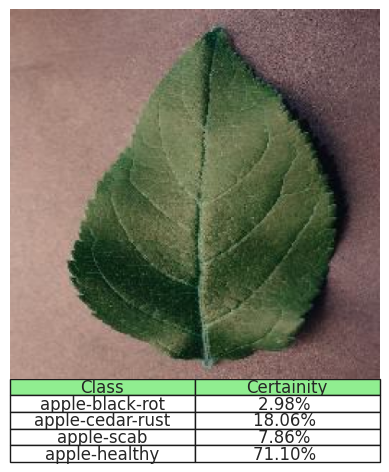

In [ ]:
image = cv2.imread("/content/data-split/valid/apple-healthy/apple-healthy1539.jpg")
get_predictions(image, model)

1/1 [==============================] - 0s 209ms/step


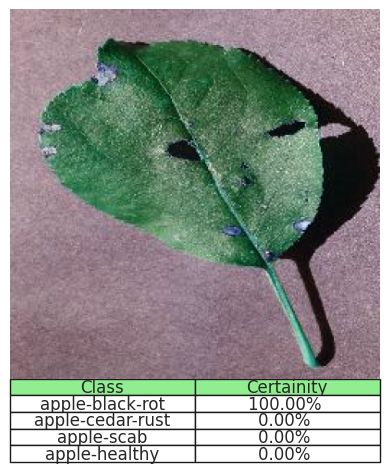

In [ ]:
image = cv2.imread("/content/data-split/valid/apple-black-rot/apple-black-rot577.jpg")
get_predictions(image, model)

1/1 [==============================] - 0s 79ms/step


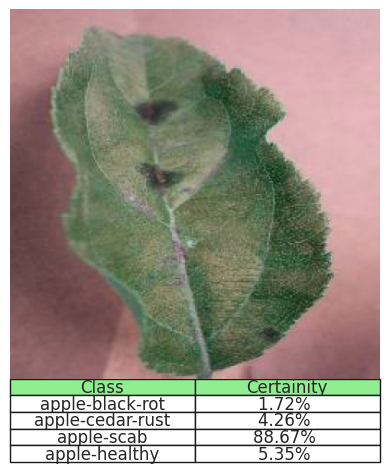

In [ ]:
image = cv2.imread("/content/data-split/valid/apple-scab/apple-scab569.jpg")
get_predictions(image, model)